In [269]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import tensorflow.keras
from tensorflow.keras import layers
import yfinance as yf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, concatenate, Flatten
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error

In [19]:
stock_data = yf.download('IVV','2008-08-08','2010-06-30')
sentiment_df=pd.read_excel(r"sentiment_analysis_results.xlsx", engine='openpyxl')

[*********************100%***********************]  1 of 1 completed


## Preprocess Data 1: Turn Sentiment Classification into Numerical Score and join both datasets

In [20]:
def sent_val(val):
    if val['Sentiment']=='negative':
        return -1
    elif val['Sentiment']=='neutral':
        return 0
    elif val['Sentiment']=='positive':
        return 1

In [21]:
sentiment_df['sentiment_value'] = sentiment_df.apply(sent_val, axis=1)
mean_df=sentiment_df.groupby('Date')['sentiment_value'].mean().reset_index()
combined=stock_data.merge(mean_df, how='inner', on='Date')
final_df=combined[['Date','Close','sentiment_value']]
stock_data=final_df.copy()

## Preprocess LSTM Input

In [57]:
def lstm_preprocess(window_size,df):
    close_prices = df[['Close','sentiment_value']]
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)
    scaler1 = MinMaxScaler(feature_range=(0,1))
    scaler2 = MinMaxScaler(feature_range=(0,1))



    scaled_data_1 = scaler1.fit_transform(values[:,0].reshape(-1,1))
    scaled_data_2 = scaler2.fit_transform(values[:,1].reshape(-1,1))
    scaled_data=np.concatenate((scaled_data_1, scaled_data_2), axis=1)
    train_data = scaled_data[0: training_data_len, :]
    x_train_stock = []
    x_train_sent = []
    y_train = []
    window=window_size
    for i in range(window, len(train_data)):
        x_train_stock.append(train_data[i-window:i, 0])
        x_train_sent.append(train_data[i-window:i, 1])
        y_train.append(train_data[i, 0])
    
    x_train_stock, y_train_stock = np.array(x_train_stock), np.array(y_train)
    x_train_stock = np.reshape(x_train_stock, (x_train_stock.shape[0], x_train_stock.shape[1], 1))

    x_train_sent = np.array(x_train_sent)
    x_train_sent = np.reshape(x_train_sent, (x_train_sent.shape[0], x_train_sent.shape[1], 1))

    y_train = np.array(y_train)

    return x_train_stock,y_train_stock,x_train_sent,y_train,scaled_data,training_data_len,scaler1,values

In [283]:

def lstm_init(x_train_stock, window_size):
    input_shape = (x_train_stock[0].shape[0], 1)

    input_stock = Input(shape=input_shape)
    input_sentiment = Input(shape=input_shape)

    lstm_stock_1 = LSTM(units=100, return_sequences=True)(input_stock)
    lstm_stock_2 = LSTM(units=100, return_sequences=False)(lstm_stock_1)

    dense_sentiment = Dense(units=10)(input_sentiment)
    flatten_sentiment = Flatten()(dense_sentiment)

    concatenated = concatenate([lstm_stock_2, flatten_sentiment])

    hidden = Dense(units=35, activation='relu')(concatenated)
    output = Dense(units=1, activation='linear')(hidden)

    model = Model(inputs=[input_stock, input_sentiment], outputs=output)
    return model

In [286]:
def model_fit(x_train_stock,x_train_sent,y_train):
    early_stopping = EarlyStopping(monitor='loss', patience=5)
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit([x_train_stock, x_train_sent], y_train, epochs=50, batch_size=32,callbacks=[early_stopping])
    return model

In [287]:
def model_test(scaled_data,window,model,values,training_data_len):
    test_data = scaled_data[training_data_len-window: , : ]
    x_test_stock = []
    x_test_sent = []
    y_test=[]
    values_data = values[training_data_len-window: , :]

    for i in range(window, len(test_data)):
        x_test_stock.append(test_data[i-window:i, 0])
        x_test_sent.append(test_data[i-window:i, 1])
        y_test.append(values_data[i, 0])


    x_test_stock = np.array(x_test_stock)
    x_test_stock = np.reshape(x_test_stock, (x_test_stock.shape[0], x_test_stock.shape[1], 1))

    x_test_sent = np.array(x_test_sent)
    x_test_sent = np.reshape(x_test_sent, (x_test_sent.shape[0], x_test_sent.shape[1], 1))

    y_test=np.array(y_test)
    predictions = model.predict([x_test_stock, x_test_sent])
    predictions = scaler1.inverse_transform(predictions)


    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    return predictions, rmse,y_test

In [331]:
window_size=14
count=0
performance=[]


for window in range(2,(window_size),2):
    x_train_stock,y_train_stock,x_train_sent,y_train,scaled_data,training_data_len,scaler1,values=lstm_preprocess(window,stock_data)
    model=lstm_init(x_train_stock,window)
    model=model_fit(x_train_stock,x_train_sent,y_train)
    predictions, rmse, y_test=model_test(scaled_data,window,model,values,training_data_len)
    performance.append([window, rmse,predictions])



Epoch 1/50
379/379 [==============================] - 34s - loss: 0.2378    
Epoch 2/50
379/379 [==============================] - 1s - loss: 0.0558     - ETA: 0s - loss: 0.06
Epoch 3/50
379/379 [==============================] - 0s - loss: 0.0326     
Epoch 4/50
379/379 [==============================] - 0s - loss: 0.0217     - ETA: 0s - loss: 0.
Epoch 5/50
379/379 [==============================] - 0s - loss: 0.0131     
Epoch 6/50
379/379 [==============================] - 0s - loss: 0.0068     
Epoch 7/50
379/379 [==============================] - 0s - loss: 0.0032     
Epoch 8/50
379/379 [==============================] - 0s - loss: 0.0024     
Epoch 9/50
379/379 [==============================] - 0s - loss: 0.0022     
Epoch 10/50
379/379 [==============================] - 0s - loss: 0.0020     - ETA: 0s - loss: 0.00
Epoch 11/50
379/379 [==============================] - 0s - loss: 0.0019     
Epoch 12/50
379/379 [==============================] - 0s - loss: 0.0018     
Epoch 13/

375/375 [==============================] - 1s - loss: 0.0024     
Epoch 26/50
375/375 [==============================] - 1s - loss: 0.0023     
Epoch 27/50
375/375 [==============================] - 1s - loss: 0.0023     
Epoch 28/50
375/375 [==============================] - 1s - loss: 0.0022     
Epoch 29/50
375/375 [==============================] - 1s - loss: 0.0022     
Epoch 30/50
375/375 [==============================] - 1s - loss: 0.0023     
Epoch 31/50
375/375 [==============================] - 1s - loss: 0.0021     
Epoch 32/50
375/375 [==============================] - 1s - loss: 0.0022     
Epoch 33/50
375/375 [==============================] - 1s - loss: 0.0022     
Epoch 34/50
375/375 [==============================] - 1s - loss: 0.0022     
Epoch 35/50
375/375 [==============================] - 1s - loss: 0.0023     
Epoch 36/50
375/375 [==============================] - 1s - loss: 0.0022     
Epoch 37/50
375/375 [==============================] - 1s - loss: 0.0021    

371/371 [==============================] - 1s - loss: 0.0028     
Epoch 30/50
371/371 [==============================] - 2s - loss: 0.0026     
Epoch 31/50
371/371 [==============================] - 1s - loss: 0.0024     
Epoch 32/50
371/371 [==============================] - 2s - loss: 0.0022     
Epoch 33/50
371/371 [==============================] - 1s - loss: 0.0028     
Epoch 34/50
371/371 [==============================] - 2s - loss: 0.0023     
Epoch 35/50
371/371 [==============================] - 2s - loss: 0.0021     
Epoch 36/50
371/371 [==============================] - 2s - loss: 0.0021     
Epoch 37/50
371/371 [==============================] - 2s - loss: 0.0021     
Epoch 38/50
371/371 [==============================] - 1s - loss: 0.0019     
Epoch 39/50
371/371 [==============================] - 1s - loss: 0.0018     
Epoch 40/50
371/371 [==============================] - 1s - loss: 0.0018     
Epoch 41/50
371/371 [==============================] - 1s - loss: 0.0018    

C:\Users\BK\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


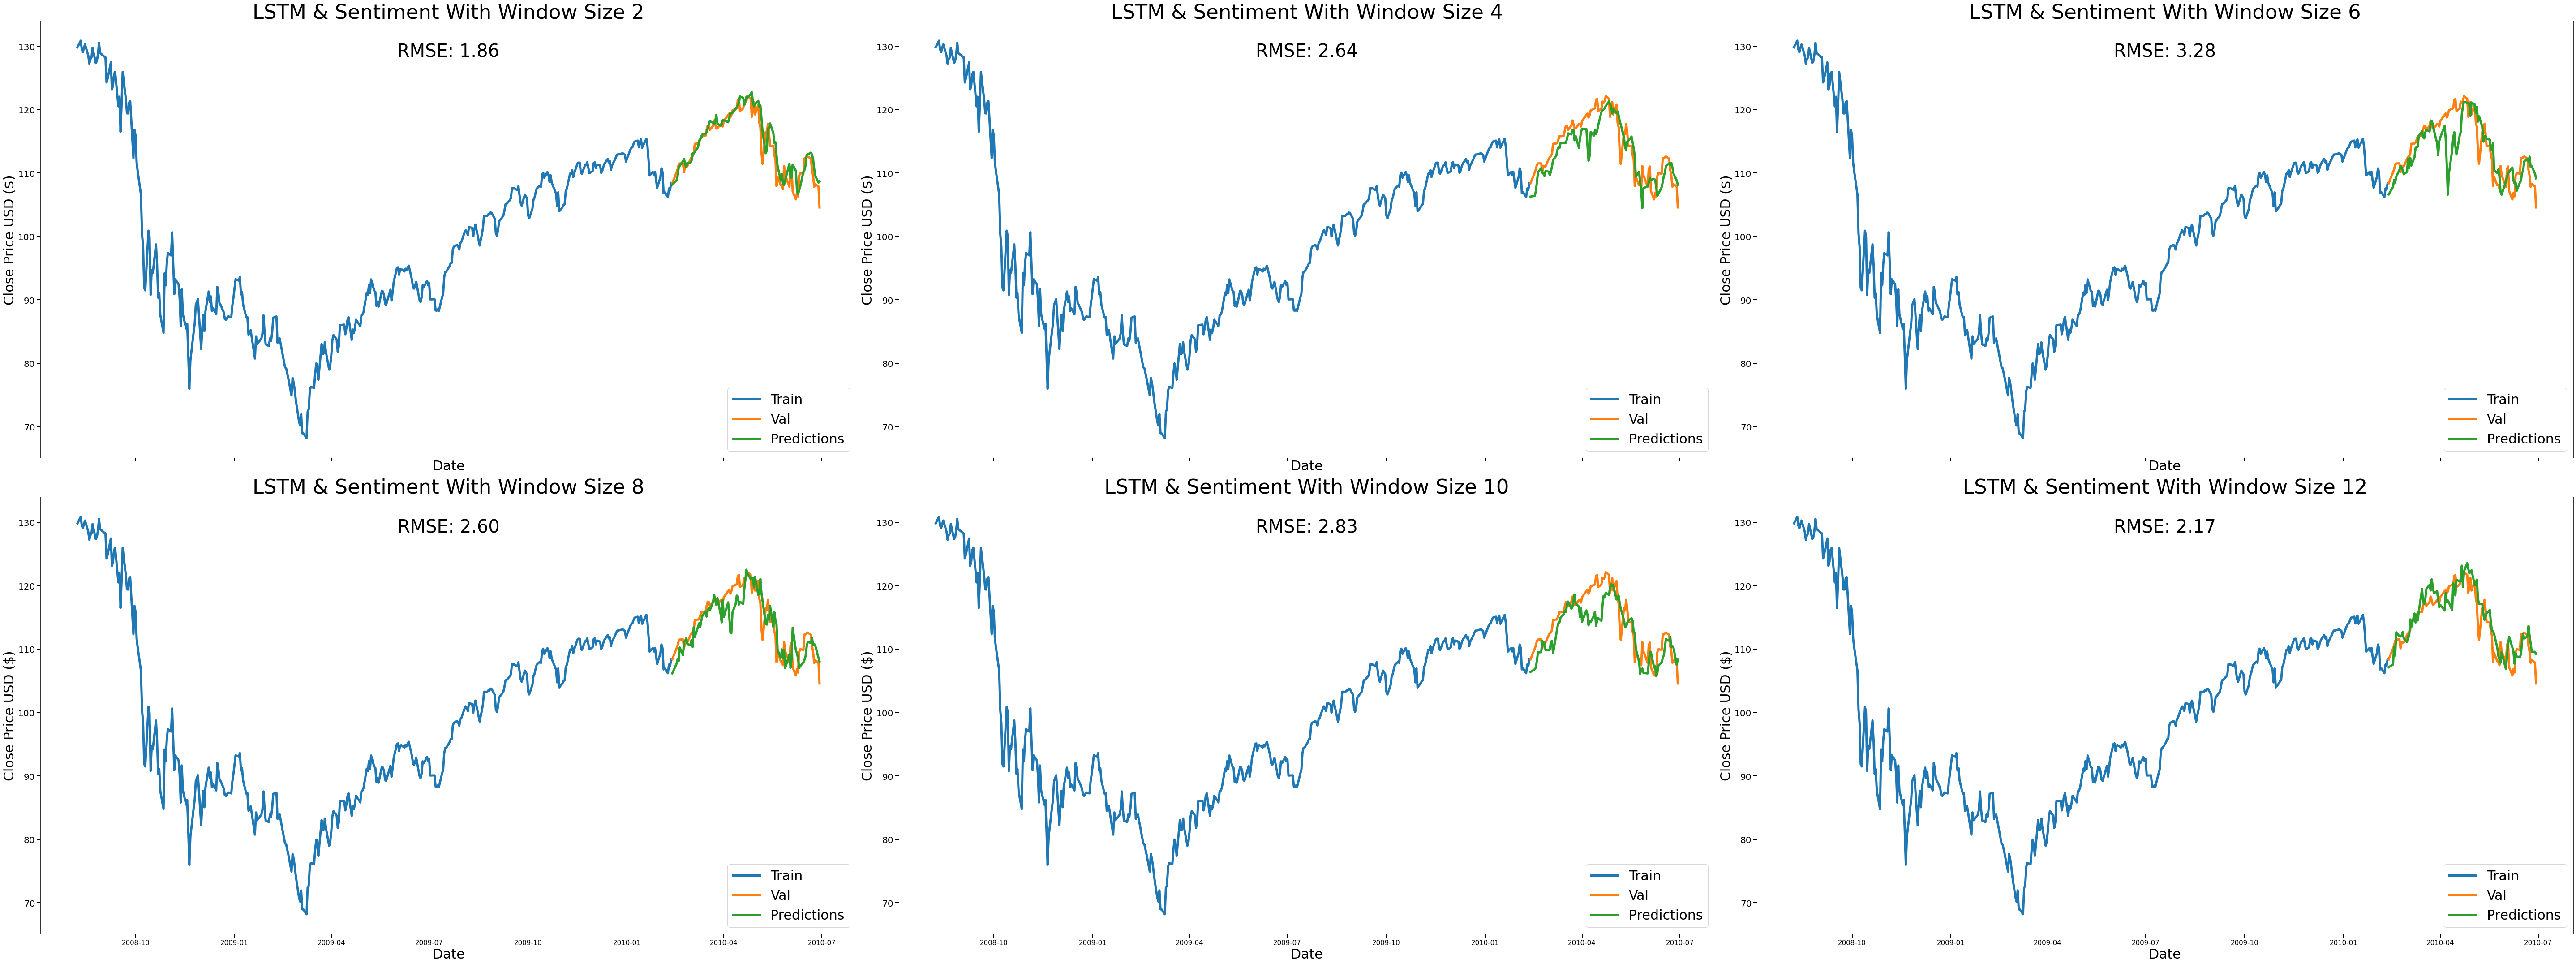

In [334]:
row=2
col=3
num_subplots=row*col


fig, axs = plt.subplots(row, col, figsize=(80, 30),sharex=True)
stock_data_2=stock_data.set_index("Date")
data = stock_data_2.filter(['Close'])
train = data[:training_data_len]

    
    
for i, ax in enumerate(axs.flat):
    if i < num_subplots:

        validation = data[training_data_len:]
        validation['Predictions'] = performance[i][2]
        ax.set_title(f'LSTM & Sentiment With Window Size {performance[i][0]}',fontsize=45)
        ax.set_xlabel('Date',fontsize=30)
        ax.set_ylabel('Close Price USD ($)',fontsize=30)
        ax.plot(train,linewidth=5)
        ax.plot(validation[['Close', 'Predictions']],linewidth=5)
        ax.legend(['Train', 'Val', 'Predictions'], loc='lower right',fontsize=30)
        ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=8)
        ax.tick_params(axis='y', which='major', labelsize=20, width=2, length=8)
        rmse = performance[i][1]

        ax.text(0.5, 0.95, f'RMSE: {rmse:.2f}', transform=ax.transAxes,
                fontsize=40, ha='center', va='top')

        plt.subplots_adjust(hspace=0.2, wspace=0.02)  
plt.tight_layout()  
plt.savefig('Sentiment/Sentiment_100.png', dpi=300)
plt.show()

        
        
        
        
        
        
        
        
     





C:\Users\BK\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


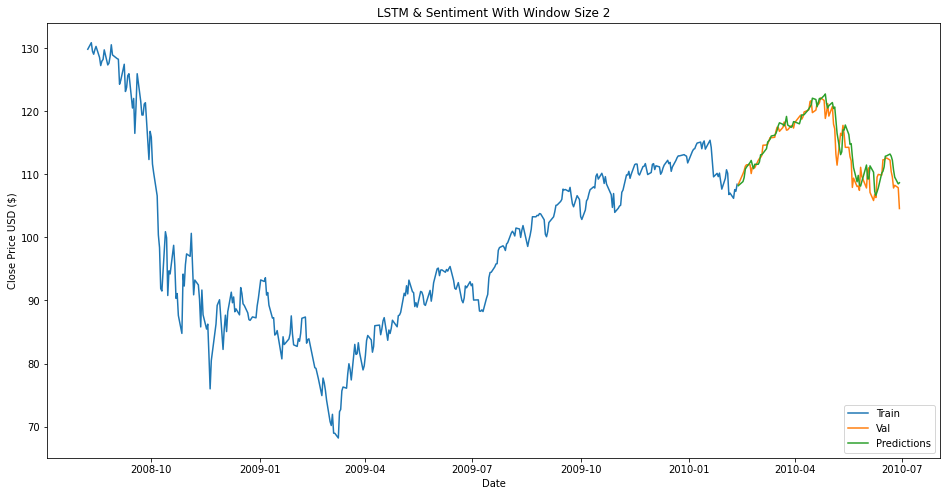

In [343]:
stock_data_2=stock_data.set_index("Date")
data = stock_data_2.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = performance[0][2]
plt.figure(figsize=(16,8))
plt.title('LSTM & Sentiment With Window Size 2')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.savefig('Sentiment/Sentiment_3.png')

plt.show()


In [336]:
validation['Predictions'] = performance[0][2]

metric_df=validation.reset_index()
metric_df['Month'] = metric_df['Date'].dt.month
monthly_rmse = metric_df.groupby('Month').apply(lambda x: np.sqrt(mean_squared_error(x['Close'], x['Predictions'])))
df_rmse = pd.DataFrame({'Month': monthly_rmse.index, 'LSTM With Sentiment RMSE': monthly_rmse.values}).set_index("Month")
df_rmse

C:\Users\BK\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,LSTM With Sentiment RMSE
Month,
2,0.896183
3,0.744491
4,1.268509
5,2.831222
6,2.312461
